# Predict my average speed on a road bike based on previous bike rides

In this notebook I will examine data gathered with strava and komoot and try to build a model that will predict my average speed of future rides.

In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import gpxpy
import matplotlib.pyplot as plt
import pandas as pd
import os
import sklearn

In [25]:
pd.set_option('display.max_rows', 1000)

I exported all my data from Strava and reading in the csv file that contains metadata for all the activities that I've done

# Import the data

In [26]:
# import the data
df = pd.read_csv('F:\\Downloads\\strava\\activities.csv')
df.loc[:, 'Activity Date'] = pd.DatetimeIndex(df['Activity Date'])
df.columns

Index(['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type',
       'Activity Description', 'Elapsed Time', 'Distance', 'Relative Effort',
       'Commute', 'Activity Gear', 'Filename', 'Athlete Weight', 'Bike Weight',
       'Elapsed Time.1', 'Moving Time', 'Distance.1', 'Max Speed',
       'Average Speed', 'Elevation Gain', 'Elevation Loss', 'Elevation Low',
       'Elevation High', 'Max Grade', 'Average Grade',
       'Average Positive Grade', 'Average Negative Grade', 'Average Cadence',
       'Max Cadence', 'Max Heart Rate', 'Average Heart Rate', 'Max Watts',
       'Average Watts', 'Calories', 'Max Temperature', 'Average Temperature',
       'Relative Effort.1', 'Total Work', 'Number of Runs', 'Uphill Time',
       'Downhill Time', 'Other Time', 'Perceived Exertion',
       'Weighted Average Power', 'Power Count', 'Prefer Perceived Exertion',
       'Perceived Relative Effort', 'Commute.1', 'Total Weight Lifted',
       'From Upload', 'Grade Adjusted Distance', 'Weath

Make a subselection of the data so that it only contains bike rides and select the relevant columns

In [27]:
# select the data on the bike
df = df[df['Activity Type'] == 'Ride']

# select the columns that we want
df = df[['Activity Name','Activity Date','Moving Time','Distance','Elevation Gain','Average Speed']]

# Fill missing data

Let's check if we have missing data

In [29]:
df.isnull().sum()

Activity Name      0
Activity Date      0
Moving Time        0
Distance           0
Elevation Gain     0
Average Speed     32
dtype: int64

average speed is missing a lot of entries, so we are going to recalculate it using the distance and moving time, which are complete data

In [30]:
# override average speed (convert to km/h) and fill in nans with distance and moving time columns
df.loc[:,'Average Speed'] = df['Distance'] / df['Moving Time'] * 3600

In [31]:
df.isnull().sum()

Activity Name     0
Activity Date     0
Moving Time       0
Distance          0
Elevation Gain    0
Average Speed     0
dtype: int64

now our data is no longer missing values

My goal is to have only the solo road bike leasure rides, so we need to filter out all other data. All of my commute rides are less than 30km and all my leasure rides are longer than that, so we make a selection based on distance

In [28]:
# filter out commute rides (reason: riding within the city is slow due to traffic and infrastructure, we want to train on solo rides outside the city). 
df = df[df['Distance'] > 30]

I make a further subselection based on some more criteria

In [32]:
# select average speeds between 18 kmh and 30 kmh (Lower than 18 is not road biking and above 30 is faulty data)
df = df[(df['Average Speed'] > 18) & (df['Average Speed'] < 30)]

# remove rides < 22km/h with elevation gain < 1000m as they are group rides or taking it easy rides. We want to train only on serious solo rides
df = df[(df['Average Speed'] >= 22) | (df['Elevation Gain'] >= 1000)]

In [33]:
# Sometimes activities get added twice. This removes double entries
df = df.groupby([df['Activity Date'].dt.year, df['Activity Date'].dt.month, df['Activity Date'].dt.day, df['Activity Date'].dt.hour]).first()
df.index = np.arange(0,len(df))

# feature engineering. Build a additional features from the features we already have

In [34]:
# we know that training makes your body stronger, so it is likely that the more km you ride the faster you become. 
# So I construct a feature which calculates the amount of km one has done in the past 90 days and I expect it to correlate positively which the average speed

days = 90
total_dist = []
for date in df['Activity Date']:
    total_dist.append(df['Distance'][(df['Activity Date'] < date) &
                                     (df['Activity Date'] > date - pd.Timedelta(days = days))].sum())
    
df['Total_dist_past_90_days'] = total_dist

In [35]:
# I calculated the positive slope of the ride as we know that uphill slowls you down. So the bigger the slope the lower the average speed is expected.
df['Slope'] = df['Elevation Gain'] / (1000 * df['Distance']) * 100

In [37]:
# lets check out some metrics that we have
df[['Moving Time','Distance','Elevation Gain','Average Speed','Total_dist_past_90_days','Slope']].head(10)

,Moving Time,Distance,Elevation Gain,Average Speed,Total_dist_past_90_days,Slope
0,11629.0,85.38,194.242996,26.431163,0.00,0.227504
1,10296.0,70.37,10.100000,24.604895,0.00,0.014353
2,13854.0,92.95,73.491898,24.153313,70.37,0.079066
3,13138.0,90.17,32.181599,24.707870,163.32,0.035690
4,15560.0,100.75,107.530998,23.309769,253.49,0.106731
5,7130.0,48.77,316.274994,24.624404,0.00,0.648503
6,5604.0,38.39,263.059998,24.661670,0.00,0.685231
7,9298.0,61.80,331.352997,23.927726,38.39,0.536170
8,9261.0,63.39,158.317001,24.641399,100.19,0.249751
9,12378.0,76.19,1223.979980,22.158992,163.58,1.606484


C:\Users\Lars\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\Lars\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


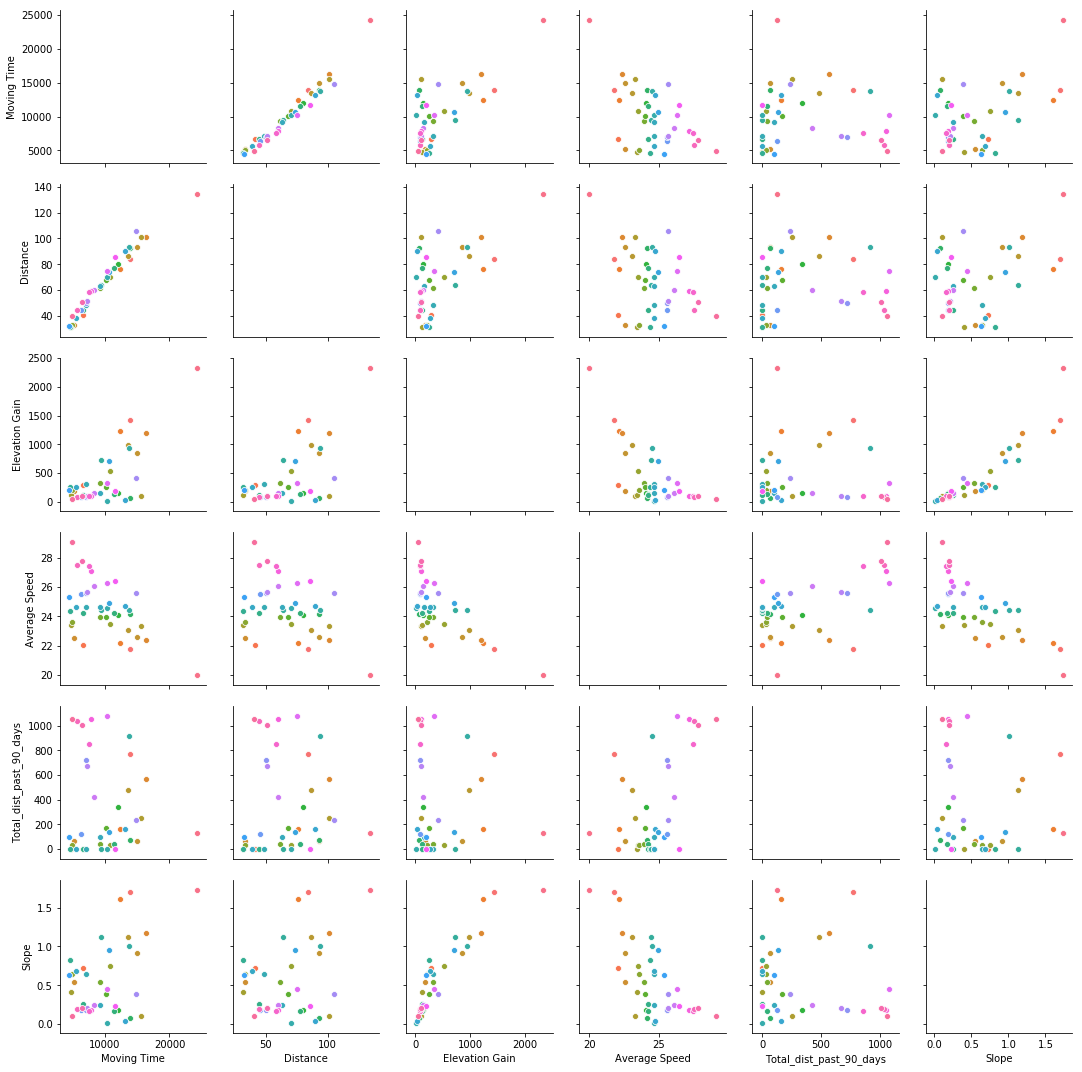

In [62]:
# make a pairplot of the variables that we have
g = sns.pairplot(df, hue = 'Average Speed')
g._legend.remove()

In [63]:
# check correlations
df.corr()

,Moving Time,Distance,Elevation Gain,Average Speed,Total_dist_past_90_days,Slope
Moving Time,1.000000,0.981169,0.710038,-0.525731,-0.046294,0.440048
Distance,0.981169,1.000000,0.604834,-0.380886,0.025805,0.320952
Elevation Gain,0.710038,0.604834,1.000000,-0.650793,-0.006962,0.913398
Average Speed,-0.525731,-0.380886,-0.650793,1.000000,0.547267,-0.672410
Total_dist_past_90_days,-0.046294,0.025805,-0.006962,0.547267,1.000000,-0.113670
Slope,0.440048,0.320952,0.913398,-0.672410,-0.113670,1.000000


It looks like the variables that correlate the best with average speed are elevation gain and slope

In [64]:
# Most of omy rides are relatively flat. Let's check correlations for flat rides (< 500m)
df[df['Elevation Gain'] < 500].corr()

,Moving Time,Distance,Elevation Gain,Average Speed,Total_dist_past_90_days,Slope
Moving Time,1.000000,0.988632,0.028979,-0.141487,-0.120009,-0.487139
Distance,0.988632,1.000000,0.008280,0.000309,-0.013109,-0.539074
Elevation Gain,0.028979,0.008280,1.000000,-0.295237,-0.262466,0.767089
Average Speed,-0.141487,0.000309,-0.295237,1.000000,0.794790,-0.420379
Total_dist_past_90_days,-0.120009,-0.013109,-0.262466,0.794790,1.000000,-0.382408
Slope,-0.487139,-0.539074,0.767089,-0.420379,-0.382408,1.000000


total distance in the past 90 days correlates very good with average speed for low elevation gain.
This might also be true for high elevation gain but we simply do not have enough data points to check that

Based on these observations the variables that we pick are Total distance in the past 90 days and Elevation gain. I could also opt to exchange Elevation Gain for Slope but for understanding sake I chose not to. 

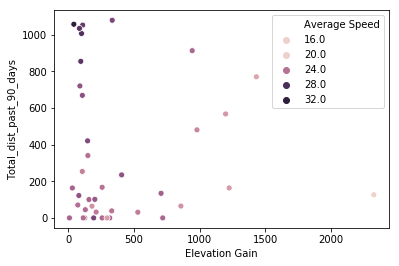

In [40]:
sns.scatterplot(x = df['Elevation Gain'], y= df['Total_dist_past_90_days'], hue = df['Average Speed'])

# Build Model

Okay so lets build a model based on Elevation Gain and Total distance in the past 90 days. 
Because we want to predict a continuous variable the easiest thing we can consider is taking a linear model.

In [43]:
### polynomial regression 
#df = df.sort_values('Elevation Gain')

# define our dependent variables
X = df[['Elevation Gain','Total_dist_past_90_days']]

# define our target variable
y = df['Average Speed']

# Splitting the dataset into a training set and a test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=101)

In [44]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [81]:
### error
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('MSE = %0.2f'%mse)
print('R2 = %0.2f'%r2)

MSE = 0.98
R2 = 0.65


# Plot model

Text(12, 22, 'R2 = 0.65')

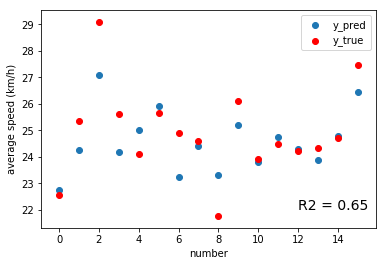

In [86]:
plt.scatter(range(len(y_pred)), y_pred, label = 'y_pred')
plt.scatter(range(len(y_test)), y_test, color = 'red', label = 'y_true')
plt.legend()
plt.xlabel('number')
plt.ylabel('average speed (km/h)')
plt.text(12,22,'R2 = %0.2f'%r2, size = 14)

It seems that our model still has trouble predicting some values, especially outliers.

let's plot the results as a function of elevation and previous distance

In [48]:
# plot result
xx1 = np.arange(0,4000.1,10)
xx2 = np.arange(0,1500.1,10)
xx1, xx2 = np.meshgrid(xx1, xx2)

xx1r, xx2r = xx1.ravel(), xx2.ravel()

In [49]:
yy = model.predict(np.array([xx1r,xx2r]).T)
yy = yy.reshape(xx1.shape)

Text(0.5, 1.0, 'Average speed as a function of Previous Distance and Elevation gain')

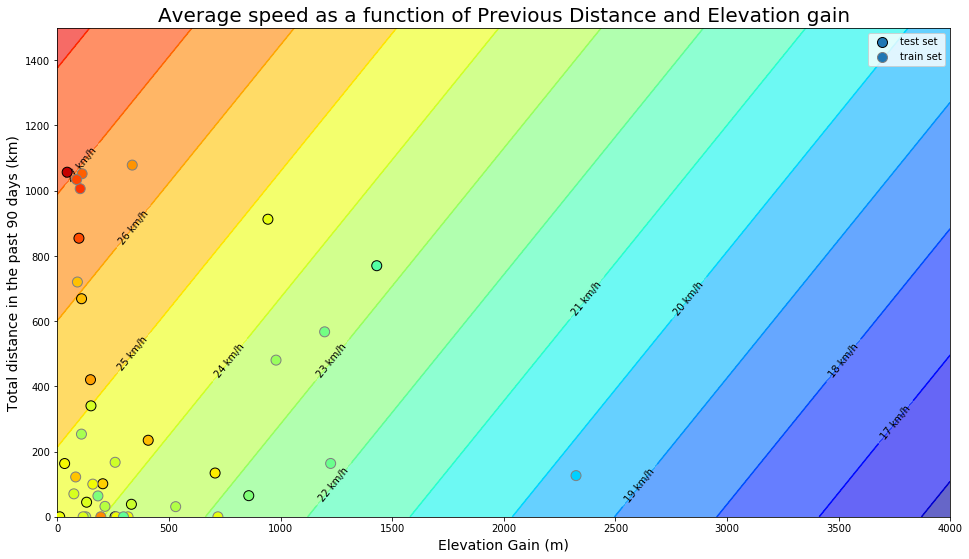

In [91]:
fig, ax = plt.subplots(figsize = (16,9))
CF = ax.contourf(xx1, xx2, yy, vmin = 15, vmax = 30, cmap = plt.cm.jet, levels = np.arange(10,30.1,1), alpha = .6)
CS = ax.contour( xx1, xx2, yy, vmin = 15, vmax = 30, cmap = plt.cm.jet, levels = np.arange(10,30.1,1))

STE = ax.scatter(X_test['Elevation Gain'], X_test['Total_dist_past_90_days'], s = 100, c = y_test, edgecolors = 'black', vmin = 15, vmax = 30, cmap = plt.cm.jet, zorder = 10, label = 'test set')
STR = ax.scatter(X_train['Elevation Gain'], X_train['Total_dist_past_90_days'], s = 100, c = y_train, edgecolors = 'grey', vmin = 15, vmax = 30, cmap = plt.cm.jet, zorder = 11, label = 'train set')
LG = ax.legend()

CL = ax.clabel(CS, CS.levels, inline=True, fmt = '%i km/h', fontsize=10, colors = 'black')

ax.set_xlabel('Elevation Gain (m)', size = 14)
ax.set_ylabel('Total distance in the past 90 days (km)', size = 14)

ax.set_ylim(0,1500)
ax.set_xlim(0,4000)

ax.set_title('Average speed as a function of Previous Distance and Elevation gain', size = 20)

# Limitations

The low number of data points available will definitely influence the accuracy of the model. I would have to make many more rides with high elevation gain in order to improve the model in this regard.

Especially for low Total Distance and Elevation Gain there are a lot of observations which vary greatly in speed, so there might be more parameters that would differenciate between these data points. That is however beyond the scope of this simple model.